# Helper Functions

In [39]:
import numpy as np

def generate_demand_points(n, area_size, distribution, n_clusters, clusters_std, rng):
    if rng is None:
        rng = np.random.default_rng()

    if distribution == "uniform":
        demand_coordinates = rng.uniform(0.0, area_size, size=(n, 2))
        return demand_coordinates
    
    if distribution == "clustered":
        centers = rng.uniform(0.0, area_size, size=(n_clusters, 2))
        cluster_idx = rng.integers(0, n_clusters, size=n)
        demand_coordinates = np.empty((n, 2), dtype=float)
        for i in range(n): # for each demand point
            center = centers[cluster_idx[i]] # get its cluster center from the idx
            demand_coordinates[i] = rng.normal(loc=center, scale=clusters_std, size=2) # make the coordinat of the current demand point locate around the cluster center
        demand_coordinates = np.clip(demand_coordinates, 0.0, area_size)
        return demand_coordinates
    

def generate_facility_locations(m, area_size,rng):
    if rng is None:
        rng = np.random.default_rng()
    
    facility_coordinates = rng.uniform(0.0, area_size, size=(m, 2))
    return facility_coordinates


def generate_distance_matrix(demand_coordinates, facility_coordinates):
    demand = demand_coordinates[:, np.newaxis, :]
    facility = facility_coordinates[np.newaxis, :, :]

    diff = demand - facility
    square_dist = np.sum(diff ** 2, axis=2)
    distance_matrix = np.sqrt(square_dist)

    return distance_matrix # distance_matrix[i, j] -> distance between demand point i and facility j


def generate_coverage_matrix(distance_matrix, radius):
    covered_bool = distance_matrix <= float(radius)
    coverage_matrix = covered_bool.astype(int)
    
    return coverage_matrix # coverage_matrix[i, j] = 1 -> demand point i is covered by facility j; coverage_matrix[i, j] = 0 -> otherwise

# Instance Generating Function

In [40]:
def generate_instance(n, m, radius, p, area_size, distribution, n_clusters, clusters_std, rng):
    if rng is None:
        rng = np.random.default_rng()

    demand_coordinates = generate_demand_points(n=n, area_size=area_size, distribution=distribution, n_clusters=n_clusters, clusters_std=clusters_std, rng=rng)
    facility_coordinates = generate_facility_locations(m=m, area_size=area_size, rng=rng)
    distance_matrix = generate_distance_matrix(demand_coordinates, facility_coordinates)
    coverage_matrix = generate_coverage_matrix(distance_matrix, radius)

    instance = {
        "n": n,
        "m": m,
        "radius": radius,
        "p": p,
        "demand_coordinates": demand_coordinates,
        "facility_coordinates": facility_coordinates,
        "distance_matrix": distance_matrix,
        "coverage_matrix": coverage_matrix
    }

    return instance


# Visualize Instance

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def plot_instance(instance, title="Instance with Radius"):
    demand = instance["demand_coordinates"]
    facility = instance["facility_coordinates"]
    radius = instance["radius"]

    fig, ax = plt.subplots()
    ax.scatter(demand[:, 0], demand[:, 1], label="Demand points")
    ax.scatter(facility[:, 0], facility[:, 1], marker="^", s=70, label="Facilities", edgecolors="r")

    for i in range(demand.shape[0]):
        circle = Circle(
            (demand[i, 0], demand[i, 1]),
            radius,
            fill=False,
            linestyle="--",
            alpha=0.4
        )
        ax.add_patch(circle)

    all_x = np.concatenate([demand[:, 0], facility[:, 0]])
    all_y = np.concatenate([demand[:, 1], facility[:, 1]])
    margin = radius * 0.5

    ax.set_xlim(all_x.min() - margin, all_x.max() + margin)
    ax.set_ylim(all_y.min() - margin, all_y.max() + margin)
    ax.set_aspect("equal", adjustable="box")

    ax.set_title(title)
    ax.legend(loc="best")
    ax.grid(True, linestyle=":")

    plt.show()

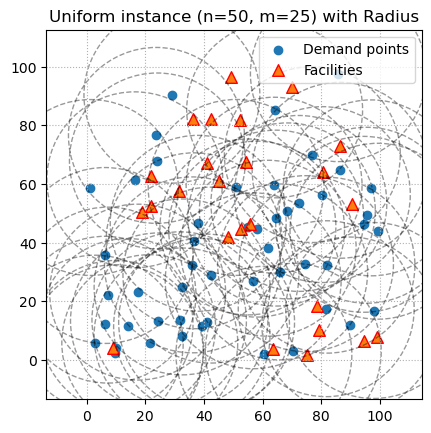

In [42]:
inst = generate_instance(
    n=50,
    m=25,
    radius=30.0,
    p=10,
    area_size=100.0,
    distribution="uniform",
    n_clusters=3,
    clusters_std=10.0,
    rng=None
)

plot_instance(inst, title="Uniform instance (n=50, m=25) with Radius")

# Defining Instances

## Instances for Solution Quality Comparison: DP vs Greedy

In [43]:
def n_m_for_size(size, rng):
    if size == "small":
        n_min, n_max = 10, 40
        m_min, m_max = 5, 20
    elif size == "medium":
        n_min, n_max = 41, 70
        m_min, m_max = 21, 35
    elif size == "large":
        n_min, n_max = 71, 100
        m_min, m_max = 36, 50
    else:
        raise ValueError("size must be small, medium, or large")
    
    n = rng.integers(n_min, n_max + 1)
    m = rng.integers(m_min, m_max + 1)
    
    return int(n), int(m)

def instance_budget(m, rng):
    fraction = rng.uniform(0.2, 0.6)
    p = int(round(fraction * m))
    p = max(1, min(m, p))

    return p

def instance_radius(rng):
    return float(rng.uniform(10.0, 50.0))

def generate_random_instance_for_size(size, distribution, rng, area_size=100.0, n_clusters=3, clusters_std=10.0):
    n, m = n_m_for_size(size, rng)
    p = instance_budget(m, rng)
    radius = instance_radius(rng)

    instance = generate_instance(n=n, m=m, radius=radius, p=p, area_size=area_size, distribution=distribution, n_clusters=n_clusters, clusters_std=clusters_std, rng=rng)
    
    return instance

# Greedy Algorithm

In [44]:
def greedy_mclp(instance):
    coverage_matrix = instance["coverage_matrix"]
    n, m = coverage_matrix.shape
    p = instance["p"]

    selected_facilities = []
    covered = np.zeros(n, dtype=bool) # set all demand points as not covered at the beginning
    
    for _ in range(p): # try to select up to p facilities (might be terminated once there's no any helpful facility anymore)
        best_facility = None
        best_benefit = 0

        for i in range(m): # traverse all facility locations
            if i in selected_facilities: # skip facilities that are already selected
                continue
            
            new_coverage = coverage_matrix[:, i].astype(bool) # extract the coverage for the current facility
            benefit = np.sum(~covered &  new_coverage) # compute the marginal benefit for the current facility
            
            if benefit > best_benefit:
                best_benefit = benefit
                best_facility = i

        if best_facility is None or best_benefit == 0: # if we couldn't find any helpful facility location
            break
        
        selected_facilities.append(best_facility) # select the facility with the best marginal benefit
        covered |= coverage_matrix[:, best_facility].astype(bool) # update covered

    total_covered = int(np.sum(covered)) # after selecting helpful facilities, compute how many demand points are covered
        
    return selected_facilities, covered, total_covered


# DP Algorithm

## Dominance_helper

In [45]:
def dominance_check(mask_a, mask_b):
    return np.all((~mask_a) | mask_b) # return True if mask_b dominates mask_a

## Add_State_Helper

In [46]:
def add_state(state_list, new_mask, new_select):
    non_dominated_states = []
    
    for mask, select in state_list:
        if dominance_check(new_mask, mask):
            return state_list # new mask is useless, discard it
        
        if dominance_check(mask, new_mask):
            continue # drop the old mask 

        non_dominated_states.append((mask, select))

    non_dominated_states.append((new_mask.copy(), list(new_select)))

    return non_dominated_states

## Main Loop

In [47]:
def DP_mclp(instance):
    A = instance["coverage_matrix"].astype(bool)
    n, m = A.shape
    p = instance["p"]

    empty_mask = np.zeros(n, dtype=bool)
    dp_states = [[] for _ in range(p + 1)] # one list for each f
    dp_states[0] = [(empty_mask, [])] # no coverage, no selected facility

    for j in range(m):
        col = A[:, j]
        new_states = [[] for _ in range(p + 1)] # store the updated non-dominated masks

        # option 1: don't select facility j
        for f in range(p + 1):
            for mask, select in dp_states[f]:
                new_states[f].append((mask.copy(), list(select)))

        #option 2: select facility j
        for f in range(p):
            for mask, select in dp_states[f]:
                new_mask = mask | col
                new_select = select + [j]
                new_states[f + 1] = add_state(new_states[f + 1], new_mask, new_select)

        dp_states = new_states

    best_coverage_value = -1
    best_mask = None
    best_select = None

    for f in range(p + 1):
        for mask, select in dp_states[f]:
            coverage_value = int(mask.sum())
            if coverage_value > best_coverage_value:
                best_coverage_value = coverage_value
                best_mask = mask
                best_select = select

    if best_mask is None:
        best_mask = np.zeros(n, dtype=bool)
        best_select = []
        best_coverage_value = 0

    return best_select, best_mask, best_coverage_value

# DP VS Greedy

In [48]:
import numpy as np
import time

def dp_vs_greedy():
    sizes = ["medium", "large"]
    total_tasks = len(sizes)

    for idx, size in enumerate(sizes, start=1):

        rng = np.random.default_rng()

        inst = generate_random_instance_for_size(
            size=size,
            distribution="clustered",
            rng=rng,
            area_size=250.0,
            n_clusters=3,
            clusters_std=10.0,
        )

        n = inst["n"]
        m = inst["m"]
        p = inst["p"]
        print(f"Instance: n = {n} demands, m = {m} facilities, p = {p} budget")

        # Greedy
        t0 = time.time()
        select_g, covered_g, total_coverage_g = greedy_mclp(inst)
        t1 = time.time()
        greedy_time = t1 - t0

        # DP
        t0 = time.time()
        select_d, covered_d, total_coverage_d = DP_mclp(inst)
        t1 = time.time()
        dp_time = t1 - t0

        print("Greedy:")
        print(f"covered: {total_coverage_g} / {n} ({total_coverage_g / n * 100:.1f}%)")
        print(f"# facilities: {len(select_g)}")
        print(f"time: {greedy_time:.3f} s")

        print("DP:")
        print(f"covered: {total_coverage_d} / {n} ({total_coverage_d / n * 100:.1f}%)")
        print(f"# facilities: {len(select_d)}")
        print(f"time: {dp_time:.3f} s")

        if total_coverage_d < total_coverage_g:
            print("WARNING: DP covered less than Greedy")
        else:
            print("Check Greedy <= DP : OK")

dp_vs_greedy()

Instance: n = 68 demands, m = 32 facilities, p = 14 budget
Greedy:
covered: 67 / 68 (98.5%)
# facilities: 4
time: 0.001 s
DP:
covered: 67 / 68 (98.5%)
# facilities: 4
time: 0.004 s
Check Greedy <= DP : OK
Instance: n = 97 demands, m = 44 facilities, p = 20 budget
Greedy:
covered: 59 / 97 (60.8%)
# facilities: 4
time: 0.000 s
DP:
covered: 59 / 97 (60.8%)
# facilities: 4
time: 0.002 s
Check Greedy <= DP : OK


# DP vs ILP

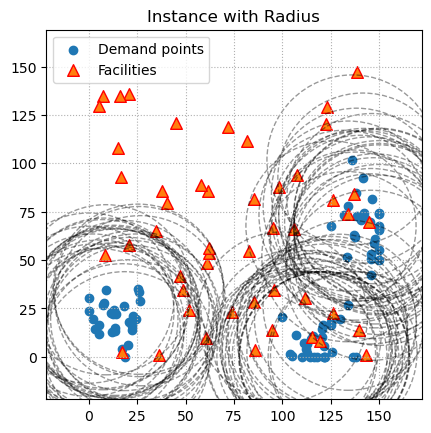

Instance: n = 84 demands, m = 49 facilities, p = 17 budget
DP:
covered: 84 / 84 (100.0%)
# facilities : 3
time: 0.0040 s

ILP (Gurobi):
covered: 84 / 84 (100.0%)
# facilities : 3
time: 0.0225 s



In [58]:
import numpy as np
import time
from gurobipy import Model, GRB

# ILP

def ilp_mclp(instance, verbose=False):
    A = instance["coverage_matrix"].astype(int)
    n, m = A.shape
    p = int(instance["p"])

    model = Model("MCLP_ILP")
    model.Params.OutputFlag = 1 if verbose else 0

    # decision variables
    x = model.addVars(m, vtype=GRB.BINARY, name="x")
    y = model.addVars(n, vtype=GRB.BINARY, name="y")

    # constraints
    for i in range(n):
        model.addConstr(y[i] <= sum(A[i, j] * x[j] for j in range(m)))

    model.addConstr(sum(x[j] for j in range(m)) <= p)

    # objective
    model.setObjective(sum(y[i] for i in range(n)), GRB.MAXIMIZE)

    model.optimize()

    selected = [j for j in range(m) if x[j].X > 0.5]

    covered_mask = np.zeros(n, dtype=bool)
    for j in selected:
        covered_mask |= A[:, j].astype(bool)
    total_covered = int(covered_mask.sum())

    return selected, covered_mask, total_covered


# ILP vs DP

def ilp_vs_dp(area_size=150.0, distribution="clustered", n_clusters=3, clusters_std=10.0):

    rng = np.random.default_rng()

    inst = generate_random_instance_for_size(
        size="large",
        distribution=distribution,
        rng=rng,
        area_size=area_size,
        n_clusters=n_clusters,
        clusters_std=clusters_std,
    )
    plot_instance(inst)
    n = inst["n"]
    m = inst["m"]
    p = inst["p"]

    print(f"Instance: n = {n} demands, m = {m} facilities, p = {p} budget")

    # DP
    t0 = time.time()
    select_dp, covered_dp, total_coverage_dp = DP_mclp(inst)
    t_dp = time.time() - t0

    # ILP
    t0 = time.time()
    select_ilp, covered_ilp, total_coverage_ilp = ilp_mclp(inst, verbose=False)
    t_ilp = time.time() - t0

    print("DP:")
    print(f"covered: {total_coverage_dp} / {n} ({total_coverage_dp / n * 100:.1f}%)")
    print(f"# facilities : {len(select_dp)}")
    print(f"time: {t_dp:.4f} s")
    print()
    print("ILP (Gurobi):")
    print(f"covered: {total_coverage_ilp} / {n} ({total_coverage_ilp / n * 100:.1f}%)")
    print(f"# facilities : {len(select_ilp)}")
    print(f"time: {t_ilp:.4f} s")
    print()

ilp_vs_dp()

# P Analysis

In [50]:
import numpy as np
import time

def dp_budget(size="medium", area_size=150.0, p_values=(3, 4, 5, 6, 7, 8), distribution="clustered", n_clusters=3, clusters_std=10.0):

    rng = np.random.default_rng()

    n, m = n_m_for_size(size, rng)

    demand_coordinates = generate_demand_points(n=n, area_size=area_size, distribution=distribution, n_clusters=n_clusters, clusters_std=clusters_std, rng=rng)
    facility_coordinates = generate_facility_locations(m=m, area_size=area_size, rng=rng)

    dist_matrix = generate_distance_matrix(demand_coordinates, facility_coordinates)

    radius = 20.0
    cover_matrix = generate_coverage_matrix(dist_matrix, radius)

    results = []

    print(f"Instance: n = {n} demands, m = {m} facilities")
    print(f"Radius = {radius}")

    for p in p_values:
        inst = {
            "n": n,
            "m": m,
            "radius": radius,
            "p": int(p),
            "demand_coordinates": demand_coordinates,
            "facility_coordinates": facility_coordinates,
            "distance_matrix": dist_matrix,
            "coverage_matrix": cover_matrix,
        }

        t0 = time.time()
        select, covered_mask, total_coverage = DP_mclp(inst)
        t1 = time.time()

        coverage_percentage = 100.0 * total_coverage / n
        facilities_used = len(select)

        results.append(
            {
                "p": int(p),
                "coverage_percentage": coverage_percentage,
                "facilities_used": facilities_used,
                "time": t1 - t0,
            }
        )

    # marginal benefits
    marginals = [None]
    for i in range(1, len(results)):
        delta = results[i]["coverage_percentage"] - results[i - 1]["coverage_percentage"]
        marginals.append(delta)

    print(f"{'Budget p':>8}  {'Coverage (%)':>13}  {'Marginal Benefit (%)':>21}")
    print("-" * 45)
    for row, marginal_benefit in zip(results, marginals):
        p = row["p"]
        cov = row["coverage_percentage"]
        if marginal_benefit is None:
            marginal_benefit_str = " -"
        else:
            marginal_benefit_str = f"{marginal_benefit:5.1f}"
        print(f"{p:8d}  {cov:13.1f}  {marginal_benefit_str:>21}")
    print()

    return results, marginals

In [53]:
budget_results, budget_marginals = dp_budget(
    size="large",
    area_size=150.0,
    p_values=(3, 4, 5, 6, 7, 8),
)

Instance: n = 98 demands, m = 49 facilities
Radius = 20.0
Budget p   Coverage (%)   Marginal Benefit (%)
---------------------------------------------
       3           66.3                      -
       4           74.5                    8.2
       5           78.6                    4.1
       6           82.7                    4.1
       7           84.7                    2.0
       8           85.7                    1.0



# Radius Analysis

In [54]:
def dp_radius(size="medium", area_size=150.0, radius_values=(10.0, 15.0, 20.0, 25.0), distribution="clustered", n_clusters=3, clusters_std=10.0, budget=8):
    
    rng = np.random.default_rng()

    n, m = n_m_for_size(size, rng)


    demand_coordinates = generate_demand_points(n=n, area_size=area_size, distribution=distribution, n_clusters=n_clusters, clusters_std=clusters_std, rng=rng)
    facility_coordinates = generate_facility_locations(m=m, area_size=area_size, rng=rng)


    dist_matrix = generate_distance_matrix(demand_coordinates, facility_coordinates)

    results = []

    print(f"Instance: n = {n} demands, m = {m} facilities, p = {budget} budget")

    for radius in radius_values:
        cover_matrix = generate_coverage_matrix(dist_matrix, radius)

        inst = {
            "n": n,
            "m": m,
            "radius": radius,
            "p": int(budget),
            "demand_coordinates": demand_coordinates,
            "facility_coordinates": facility_coordinates,
            "distance_matrix": dist_matrix,
            "coverage_matrix": cover_matrix,
        }

        t0 = time.time()
        select, covered_mask, total_coverage = DP_mclp(inst)
        t1 = time.time()

        coverage_percentage = 100.0 * total_coverage / n
        facilities_used = len(select)
        efficiency = coverage_percentage / max(facilities_used, 1)

        results.append(
            {
                "radius": float(radius),
                "coverage_percentage": coverage_percentage,
                "facilities_used": facilities_used,
                "efficiency": efficiency,
                "time": t1 - t0,
            }
        )

    print(
        f"{'Radius':>8}  {'Coverage (%)':>13}  "
        f"{'Facilities used':>16}  {'Efficiency':>11}"
    )
    print("-" * 60)
    for row in results:
        r = row["radius"]
        cov = row["coverage_percentage"]
        f_used = row["facilities_used"]
        eff = row["efficiency"]
        print(f"{r:8.1f}  {cov:13.1f}  {f_used:16d}  {eff:11.2f}")
    print()

    return results

In [56]:
radius_results = dp_radius(
    size="large",
    area_size=150.0,
    radius_values=(10.0, 15.0, 20.0, 25.0),
    budget=8,
)

Instance: n = 84 demands, m = 38 facilities, p = 8 budget
  Radius   Coverage (%)   Facilities used   Efficiency
------------------------------------------------------------
    10.0           63.1                 7         9.01
    15.0           84.5                 6        14.09
    20.0           97.6                 6        16.27
    25.0          100.0                 4        25.00

